Skorzystałem z prostego obwodu z laboratorium 3 zadanie 1

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy


# Loading your IBM Q account(s)
provider = IBMQ.load_account()
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_london


Przygotowanie obwodu:


In [2]:
circ = QuantumCircuit(2)
circ.i(0)
circ.y(0)
circ.i(0)
circ.i(0)
circ.i(0)
circ.i(0)


Pokazanie obwodu:

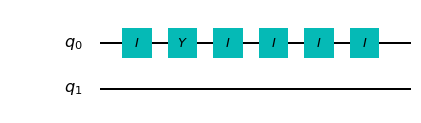

In [3]:
circ.draw()

Przygotowanie obwodu z pomiarem na końcu

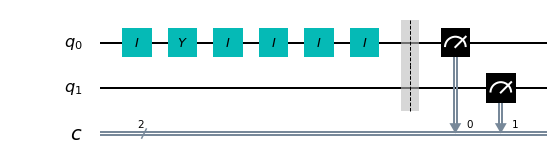

In [4]:
meas = QuantumCircuit(2, 2)
meas.barrier(range(2))
meas.measure(range(2),range(2))
qc = circ+meas
qc.draw()

Test na dekoherencję:

In [5]:
sim_backend = Aer.get_backend('qasm_simulator')
sim_job = execute(qc, sim_backend, shots = 1024)
sim_result = sim_job.result()

real_backend = device
real_job = execute(qc, backend = real_backend)
job_monitor(real_job)
real_result = real_job.result()

Job Status: job has successfully run


Wyniki:

In [6]:
sim_counts = sim_result.get_counts(qc)
print(sim_counts)
real_counts = real_result.get_counts(qc)
print(real_counts)

{'01': 1024}
{'11': 17, '01': 928, '00': 79}


Próba poprawy wyników

Opis algorytmu:
1. Przygotowanie obwodów do kalibracji pomiarów dla każdego z 2^n stanów bazowych (w tym przypadku 4)
2. Uruchomienie wszystkich obwodów i wykonanie pomiarów
3. Wyznaczenie macierzy kalibracji na podstawie pomiarów
4. Wykonanie prawdziewego eksperymentu, którego wyniki chcemy skorygować
5. Aplikacja macierzy kalibracji do wyników (w tym przypadku użyję metody najmniejszych kwadratów).

In [7]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

#preparing all circuits
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

[[0.99414062 0.09179688 0.04492188 0.00488281]
 [0.00195312 0.90234375 0.         0.04589844]
 [0.00390625 0.         0.953125   0.06933594]
 [0.         0.00585938 0.00195312 0.87988281]]


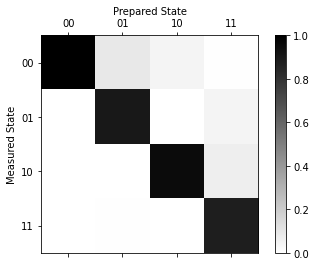

In [8]:
# Execute the calibration circuits without noise
backend = device
job = qiskit.execute(meas_calibs, backend=backend)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

meas_fitter.plot_calibration()

In [9]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.932373


In [10]:
job = qiskit.execute([qc], backend=backend)
results = job.result()

In [11]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

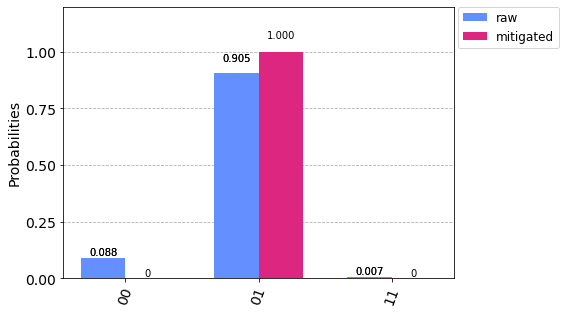

In [12]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

Udało się poprawić wynik do wartości idealnych.